<a href="https://colab.research.google.com/github/PragyaKumari2203/Image-Captioning-Model/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pre-requisites

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Image-Captioning-Model

/content/drive/MyDrive/Image-Captioning-Model


In [ ]:
# Install dependencies
!pip install -r requirements.txt

# **Data Preparation**




In [ ]:
import os
import torch
from torch import nn
from transformers import AutoTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, models
import numpy as np
import random

In [ ]:
PATH_TO_CAPTIONS = "./Flickr8k_text/Flickr8k.token.txt"
PATH_TO_IMAGES = "./Flickr8k_Dataset"
PATH_TO_TRAINING_DATA = "./Flickr8k_text/Flickr_8k.trainImages.txt"
PATH_TO_VALIDATION_DATA = "./Flickr8k_text/Flickr_8k.devImages.txt"
PATH_TO_TEST_DATA = "./Flickr8k_text/Flickr_8k.testImages.txt"

## Loading image-caption pairs

In [ ]:
def load_captions(filename):
  captions = {}
  with open(filename, 'r', encoding='utf-8') as f:
    for line in f:
      parts = line.strip().split('\t')
      if len(parts) < 2:
        continue
      jpg_filename, caption = parts[0] .split('#')[0], parts[1]
      if jpg_filename not in captions:
        captions[jpg_filename] = []
      captions[jpg_filename].append(caption)
  return captions

## Image and text preprocessing

In [ ]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(caption,max_length = 30):
  tokens = tokenizer(
      caption,
      max_length = max_length,
      padding = "max_length",
      truncation = True,
      return_tensors = "pt"
  )
  return tokens.input_ids.squeeze(0), tokens.attention_mask.squeeze(0)

def image_transforms():
    return transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

## Writing Custom Dataset

In [ ]:
class Flickr8kDataset(Dataset):
  def __init__(self,image_dir,captions_dict,image_filenames,tokenizer=None,transform=None,max_length=30):
    """
        Args:
            image_dir (str): Path to the directory containing images.
            captions_dict (dict): Dictionary mapping image filenames to a list of captions.
            image_filenames (list): List of image filenames for this dataset split (train/val/test).
            tokenizer: Hugging Face tokenizer for captions.
            transform: Image transformations.
            max_length (int): Maximum token length for captions, default = 30.
    """
    self.image_dir = image_dir
    self.captions_dict = captions_dict
    self.image_filenames = image_filenames
    self.tokenizer = tokenizer
    self.transform = transform
    self.max_length = max_length

  def __len__(self):
    return len(self.image_filenames)

  def __getitem__(self,idx):
    image_filename = self.image_filenames[idx]
    image_path = os.path.join(self.image_dir,image_filename)
    image = Image.open(image_path).convert("RGB")

    if self.transform:
      image = self.transform(image)

    captions = self.captions_dict[image_filename]
    caption_sel = captions[torch.randint(0,len(captions),(1,)).item()]
    input_ids, attention_mask = self.tokenizer(caption_sel, self.max_length)

    return image, input_ids, attention_mask

In [ ]:
def image_list(filepath):
  with open(filepath,'r') as f:
    return [line.strip() for line in f.readlines()]

training_data = image_list(PATH_TO_TRAINING_DATA)
validation_data = image_list(PATH_TO_VALIDATION_DATA)
test_data = image_list(PATH_TO_TEST_DATA)

print(f"Number of training images: {len(training_data)}")
print(f"Number of validation images: {len(validation_data)}")
print(f"Number of test images: {len(test_data)}")

Number of training images: 6000
Number of validation images: 1000
Number of test images: 1000


In [ ]:
captions = load_captions(PATH_TO_CAPTIONS)

example_dataset = Flickr8kDataset(
    image_dir = PATH_TO_IMAGES,
    captions_dict = captions,
    image_filenames = training_data,
    tokenizer = tokenize,
    transform = image_transforms(),
    max_length = 30
)

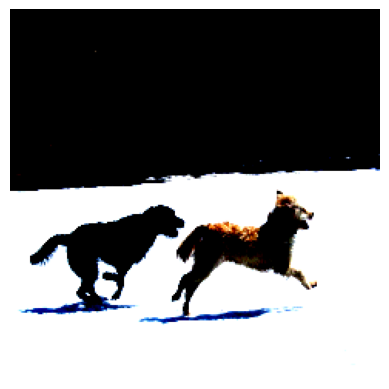

Tokenized IDs: tensor([ 101, 2048, 6077, 2377, 2362, 1999, 1996, 4586, 1012,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0])
Input IDs to text: [CLS] two dogs play together in the snow. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Input IDs to tokens: ['[CLS]', 'two', 'dogs', 'play', 'together', 'in', 'the', 'snow', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
fig = plt.figure()
image, input_ids, attention_mask = example_dataset[0]
plt.imshow(image.permute(1,2,0))
plt.axis('off')
plt.show()

print(f"Tokenized IDs: {input_ids}")
print(f"Input IDs to text: {tokenizer.decode(input_ids)}")
print(f"Input IDs to tokens: {tokenizer.convert_ids_to_tokens(input_ids)}")

## Creating dataloaders

In [ ]:
training_dataset = Flickr8kDataset(
    image_dir = PATH_TO_IMAGES,
    captions_dict = captions,
    image_filenames = training_data,
    tokenizer = tokenize,
    transform = image_transforms(),
    max_length = 30
)

valid_dataset = Flickr8kDataset(
    image_dir = PATH_TO_IMAGES,
    captions_dict = captions,
    image_filenames = validation_data,
    tokenizer = tokenize,
    transform = image_transforms(),
    max_length = 30
)

test_dataset = Flickr8kDataset(
    image_dir = PATH_TO_IMAGES,
    captions_dict = captions,
    image_filenames = test_data,
    tokenizer = tokenize,
    transform = image_transforms(),
    max_length = 30
)

In [ ]:
train_dataloader = DataLoader(training_dataset,batch_size = 32,shuffle = True, num_workers = 2)
valid_dataloader = DataLoader(valid_dataset,batch_size = 32,shuffle = False,num_workers = 2)
test_dataloader = DataLoader(test_dataset,batch_size = 32,shuffle = False,num_workers = 2)

In [ ]:
for batch in train_dataloader:
    images, input_ids, attn_masks = batch
    print(f"Batch Image Shape: {images.shape}")
    print(f"Batch Token Shape: {input_ids.shape}")
    print(f"Batch Attention Mask Shape: {attn_masks.shape}")
    break

Batch Image Shape: torch.Size([32, 3, 240, 240])
Batch Token Shape: torch.Size([32, 30])
Batch Attention Mask Shape: torch.Size([32, 30])


# Model Architecture

## Model definition

In [ ]:
class Encoder(nn.Module):
  def __init__(self,embed_dim):
    super(Encoder, self).__init__()
    self.efficientnet_b1 = models.efficientnet_b1(weights='DEFAULT')
    self.out_channels = self.efficientnet_b1.features[-1][0].out_channels
    self.efficientnet_b0 = nn.Sequential(*list(self.efficientnet_b1.children())[:-1])
    self.fc_out = nn.Linear(self.out_channels,embed_dim)

  def forward(self,images):
    # images = [batch_size,3,240,240]
    with torch.no_grad():
      # features = [batch_size,1280,1,1] => [batch_size,1280]
      features = self.efficientnet_b0(images).squeeze(-1).squeeze(-1)
    # self.fc_out(..) = [batch_size,embed_dim]
    return self.fc_out(features)

In [ ]:
class Decoder(nn.Module):
  def __init__(self,embed_dim,vocab_size):
    super(Decoder,self).__init__()
    self.bert = BertModel.from_pretrained("bert-base-uncased")
    self.token_embeddings = self.bert.embeddings.word_embeddings
    self.fc_out = nn.Linear(embed_dim,vocab_size)

  def forward(self, input_ids, attention_mask, image_embedding):
    # input_ids = [batch_size,max_length]
    # attention_mask = [batch_size,max_length]

    # token_embeds = [batch_size,max_length,embed_dim]
    token_embeds = self.token_embeddings(input_ids)
    # image_embedding = [batch_size,embed_dim] => [batch, 1, embed_dim]
    image_embedding = image_embedding.unsqueeze(1)
    #fused_input = [batch_size,max_length+1, embed_dim]
    fused_input = torch.cat([image_embedding, token_embeds], dim=1)
    extended_mask = torch.cat([torch.ones((attention_mask.size(0), 1),
                                          device=attention_mask.device), attention_mask], dim=1)
    # output = [batch_size,max_length,embed_dim]
    outputs = self.bert(inputs_embeds=fused_input,attention_mask=extended_mask)
    # self.fc_out(..) = [batch_size,max_length+1,vocab_size]
    return self.fc_out(outputs.last_hidden_state)

In [ ]:
class ImageCaptioningModel(nn.Module):
  def __init__(self,embed_dim,vocab_size):
    super(ImageCaptioningModel,self).__init__()
    self.encoder = Encoder(embed_dim)
    self.decoder = Decoder(embed_dim,vocab_size)

  def forward(self,images,input_ids,attention_mask):
    # images = [batch,3,240,240]
    # input_ids = [batch,max_length]
    # attention_mask = [batch,max_length]

    # image_features = [batch_size,embed_dim]
    image_features = self.encoder(images)
    # output = [batch_size,max_length,vocab_size]
    outputs = self.decoder(input_ids, attention_mask, image_features)
    return outputs

# Training the model

## Model initialization

In [ ]:
embed_dim = 768  #BERT's embedding dimension
vocab_size = tokenizer.vocab_size   #BERT's vocab size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ImageCaptioningModel(embed_dim,vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 141,731,650 trainable parameters


## Training and evaluation loops

In [ ]:
def train_fn(model,dataloader,optimizer,criterion,device):
  model.train()
  total_loss = 0.0
  for images,captions,attention_masks in dataloader:
    images,captions,attention_masks = images.to(device),captions.to(device),attention_masks.to(device)
    optimizer.zero_grad()
    # outputs = [batch_size,max_length,vocab_size]
    outputs = model(images,captions,attention_masks)
    logits = outputs[:, 1:, :]
    # outputs = [batch_size,max_length,vocab_size] => [batch_size * max_length, vocab_size]
    # captions = [batch_size,max_length] => [batch_size * max_length]
    loss = criterion(logits.contiguous().view(-1, logits.shape[-1]), captions.contiguous().view(-1))
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  return total_loss / len(dataloader)


def evaluation_fn(model,dataloader,criterion,device):
  model.eval()
  eval_loss = 0.0
  for images,captions,attention_masks in dataloader:
    images,captions,attention_masks = images.to(device),captions.to(device),attention_masks.to(device)
    with torch.no_grad():
      outputs = model(images,captions,attention_masks)
      logits = outputs[:, 1:, :]
      loss = criterion(logits.contiguous().view(-1, logits.shape[-1]), captions.contiguous().view(-1))
      eval_loss += loss.item()
  return eval_loss / len(dataloader)

## Finetuning

In [ ]:
print(f"Training on: {device}")

Training on: cuda


In [ ]:
n_epochs = 5
best_eval_loss = float('inf')

for epoch in range(n_epochs):
  train_loss = train_fn(model,train_dataloader,optimizer,criterion,device)
  eval_loss = evaluation_fn(model,valid_dataloader,criterion,device)

  if eval_loss < best_eval_loss:
    best_eval_loss = eval_loss
    torch.save(model.state_dict(), "best_model.pth")

  print(f"Epoch {epoch+1}/{n_epochs}, Loss: {train_loss:.4f}")
  print(f"Validation Loss: {eval_loss / len(valid_dataloader):.4f}")
  print("-"*50)

## Model evaluation

In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
test_loss = evaluation_fn(model, test_dataloader, criterion, device)
print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 0.132 | Test PPL:   1.141 |


# Caption generation

In [ ]:
def generate_caption(model, image_path, tokenizer, device, max_length=30):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    transform = image_transforms()
    # image_tensor = [3,240,240] => [1,3,240,240]
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        #image_features = [1,embed_dim]
        image_features = model.encoder(image_tensor)

    #input_ids = [1,1]
    input_ids = torch.tensor([[tokenizer.cls_token_id]], device=device)
    #attention_mask = [1,1]
    attention_mask = torch.ones_like(input_ids, device=device)

    for _ in range(max_length):
        #outputs = [1,max_length,vocab_size]
        outputs = model.decoder(input_ids, attention_mask,image_features)
        #next_token_logits = [1,vocab_size]
        next_token_logits = outputs[:, -1, :]
        #next_token_id = [1] => [1,1]
        next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)
        #input_ids = [1,t] => [1,t+1], t = length of input_ids
        input_ids = torch.cat([input_ids, next_token_id], dim=1)
        #attention_mask = same as input_ids
        attention_mask = torch.ones_like(input_ids)
        if next_token_id.item() in [tokenizer.sep_token_id, tokenizer.pad_token_id]:
            break

    caption = tokenizer.decode(input_ids[0][1:], skip_special_tokens=True)
    return caption

In [ ]:
test_image = random.choice(test_data)
test_image_path = os.path.join(PATH_TO_IMAGES,test_image)
caption = generate_caption(model,test_image_path,tokenizer,device)

image = Image.open(test_image_path)
plt.imshow(image)
plt.title(caption)
plt.axis('off')
plt.show()
print("Caption:", caption)